In [1]:
import os
import pandas as pd
import soundfile
import fnmatch
import yaml
from wav2letter.datasets import Dataset, LSDataModule, DataModuleRF
from wav2letter.models import LitWav2Letter, Wav2LetterRF
import torchaudio
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.io import wavfile
import auditory_cortex.regression as Reg
import auditory_cortex.utils as utils
import numpy as np
# import cupy as cp
import pickle
import time
from utils_jgm.tikz_pgf_helpers import tpl_save

import auditory_cortex.analysis.config as config
from auditory_cortex import results_dir
import auditory_cortex.helpers as helpers
import auditory_cortex.analysis.analysis as analysis

task_optim_dir = os.path.join(results_dir, 'cross_validated_correlations', 'task_optimization')

c:\Users\ahmedb\anaconda3\envs\auditory_ctx\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Task optimization plott...

#### decoding matrix

In [2]:
filename = 'decoder_matrix.pkl'
filepath = os.path.join(task_optim_dir, filename)
if os.path.isfile(filepath):
    print("Filepath exists, reading existing file...")
    with open(filepath, 'rb') as file:
        decoder_matrix = pickle.load(file) 

Filepath exists, reading existing file...


Text(0.5, 1.0, 'Histogram of beta weights for ch-60')

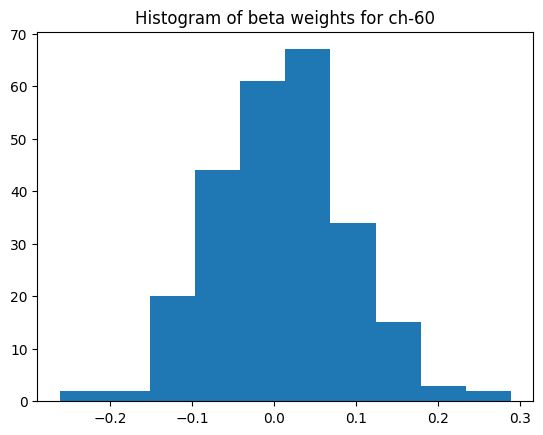

In [3]:
epoch = 4
id = 1
ch = 60
# decoder_matrix[f'beta_200206_epoch{epoch}'][id][:, ch].shape

plt.hist(decoder_matrix[f'beta_200206_epoch{epoch}'][id][:, ch])
plt.title(f"Histogram of beta weights for ch-{ch}")

In [8]:
import matplotlib.cm as cm

def plot_decoder_matrices(layer_id):
    # layer_id = 5
    session = 200206
    epochs = [4, 5, 7, 8]
    layers = {5:0, 6:1, 7:2, 8:3, 9:4, 10:5}
    id = layers[layer_id]

    fig, ax = plt.subplots(nrows=1, ncols=len(epochs))
    # epoch = 4
    for i, epoch in enumerate(epochs):
        map = decoder_matrix[f'beta_200206_epoch{epoch}'][id]
        axesImage = ax[i].imshow(map, vmin=-0.5, vmax=0.5, \
                     cmap='bwr')
        ax[i].set_title(f"Epoch-{epoch}")

        # ax[i].set_yticks([])
        # ax[i].set_xticks([])

    cax = plt.axes([0.95, 0.20, 0.05, 0.6])
    # cax = fig.add_axes([0.95, 0.20, 0.05, 0.6])

    plt.title("parameter \n values")
    plt.yticks([])
    plt.xticks([])
    plt.colorbar(axesImage,
        #cm.ScalarMappable(cmap='bwr'),
         cax=cax,
    )
    plt.suptitle(f"Decoding matrices for (session-{session}), layer-{layer_id}")
    plt.show()


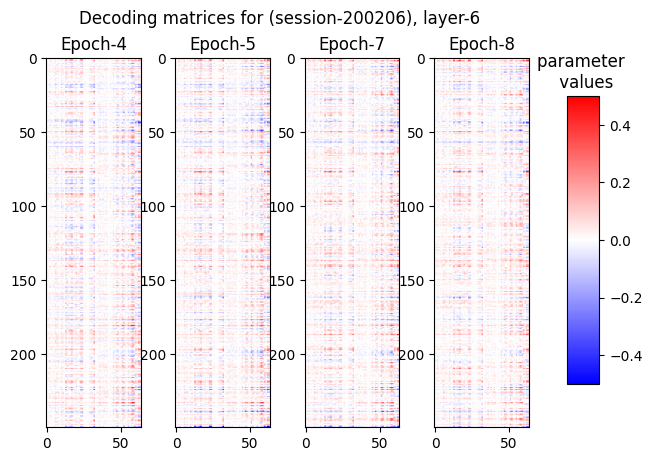

In [9]:
layer_id = 6
plot_decoder_matrices(layer_id)

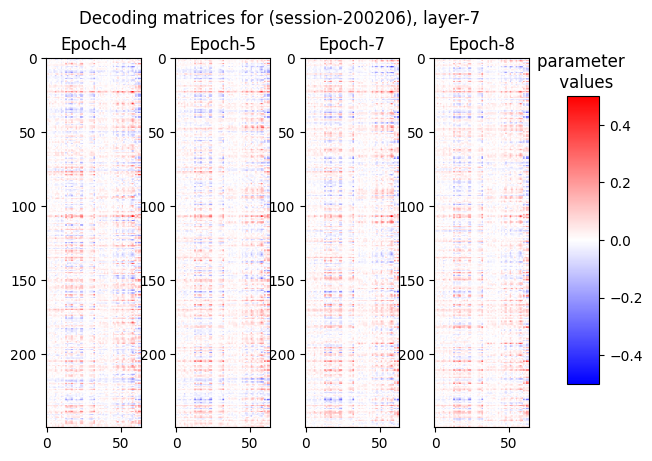

In [10]:
layer_id = 7
plot_decoder_matrices(layer_id)

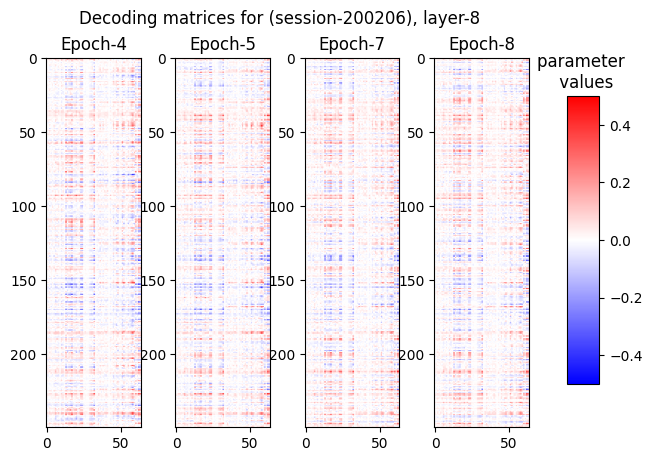

In [11]:
layer_id = 8
plot_decoder_matrices(layer_id)

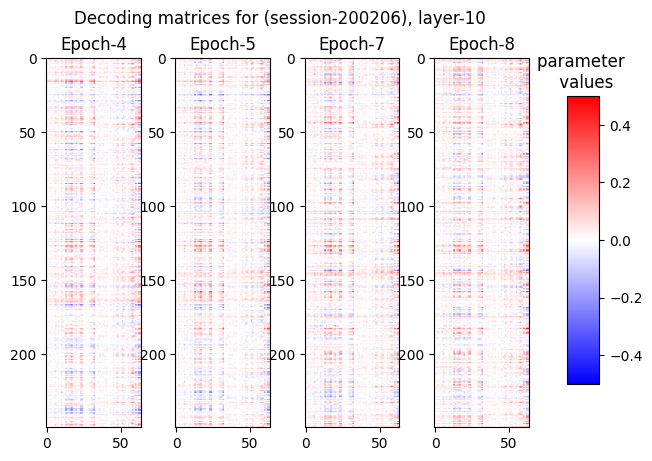

In [12]:
layer_id = 10
plot_decoder_matrices(layer_id)

#### correlations vs training epcohs

In [109]:
filenames = os.listdir(task_optim_dir)
# filter out the file_names other than '*corr_results*'
filenames = [filename for filename in filenames if 'corr_results' in filename]
filenames.sort()

In [111]:
filenames

['wav2letter_modified_E0_correlations_w2l_untrained_corr_results.csv',
 'wav2letter_modified_E1_corr_results.csv',
 'wav2letter_modified_E2_corr_results.csv',
 'wav2letter_modified_E3_corr_results.csv',
 'wav2letter_modified_E4_corr_results.csv',
 'wav2letter_modified_E5_corr_results.csv',
 'wav2letter_modified_E6_corr_results.csv',
 'wav2letter_modified_E7_corr_results.csv',
 'wav2letter_modified_E8_corr_results.csv']

In [20]:
# file = files[00]
# path = os.path.join(task_optim_dir, file)
# e1_data = pd.read_csv(path)
# task_optim_data.append(e1_data[e1_data['normalizer'] > 0.1]['test_cc_raw'].values)

In [186]:
# file = files[0]
task_optim_data = []
sig_channels = []
sessions = []
normalizers = []
layer = 5
bin_width = 20
delay = 0
threshold = 0.11
for file in filenames:
    path = os.path.join(task_optim_dir, file)
    e1_data = pd.read_csv(path)
    select_data = e1_data[
                        (e1_data['normalizer'] > threshold) & \
                        (e1_data['layer'] == layer) & \
                        (e1_data['bin_width'] == bin_width) & \
                        (e1_data['N_sents'] >= 499) & \
                        (e1_data['delay'] == delay)
                        ]
    task_optim_data.append(select_data['test_cc_raw'].values)
    sig_channels.append(select_data['channel'].values)
    sessions.append(select_data['session'].values)
    normalizers.append(select_data['normalizer'].values)


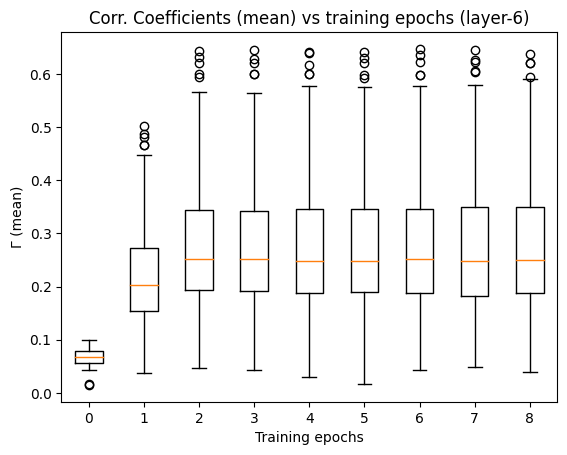

In [185]:
fig, ax = plt.subplots()
ax.boxplot(task_optim_data, positions=np.arange(len(task_optim_data)))
ax.set_xlabel('Training epochs')
ax.set_ylabel('\u0393 (mean)')
plt.title(f"Corr. Coefficients (mean) vs training epochs (layer-{layer})")


plt.show()

#### ladder plot..

In [152]:
epoch = 7
epoch_correlations = task_optim_data[epoch]
next_epoch_correlations = task_optim_data[epoch+1]

IndexError: index 139 is out of bounds for axis 0 with size 139

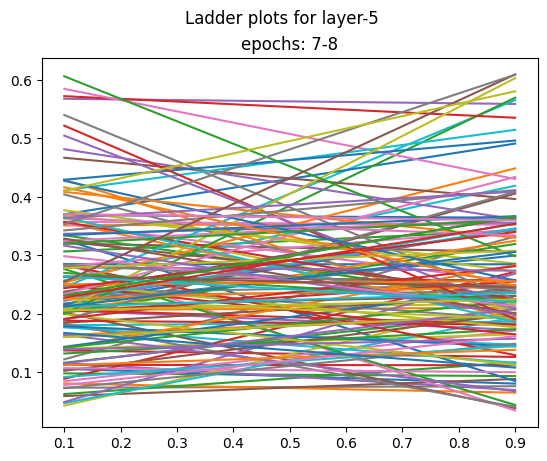

In [190]:
cols = 1
fig, ax = plt.subplots(ncols=cols, nrows=1)
x_array = [0.1, 0.9]

titles = ['epochs: 4-5', 'epochs: 7-8']
epochs = {
    0: [4,5],
    1: [7,8]    
}

plt.suptitle(f"Ladder plots for layer-{layer}")
c = 1
ids = epochs[c]
seq1 = task_optim_data[ids[0]]
seq2 = task_optim_data[ids[1]]
for i, y1 in enumerate(epoch_correlations):        
    y_array = [seq1[i], seq2[i]]
    ax.plot(x_array, y_array)
    ax.set_title(titles[c])
ax.set_xticks([])

In [153]:
epoch_correlations.shape

(143,)

In [154]:
next_epoch_correlations.shape

(139,)

IndexError: index 142 is out of bounds for axis 0 with size 142

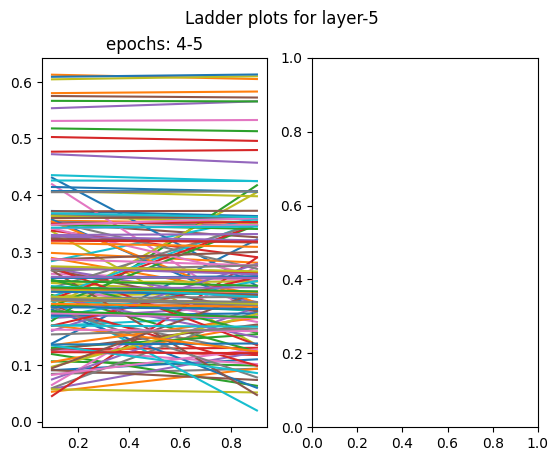

In [188]:
cols = 2
fig, ax = plt.subplots(ncols=cols, nrows=1)
x_array = [0.1, 0.9]

titles = ['epochs: 4-5', 'epochs: 7-8']
epochs = {
    0: [4,5],
    1: [7,8]    
}

plt.suptitle(f"Ladder plots for layer-{layer}")
for c in range(cols):
    # c = 0
    ids = epochs[c]
    seq1 = task_optim_data[ids[0]]
    seq2 = task_optim_data[ids[1]]
    for i, y1 in enumerate(epoch_correlations):        
        y_array = [seq1[i], seq2[i]]
        ax[c].plot(x_array, y_array)
        ax[c].set_title(titles[c])
    ax[c].set_xticks([])


Text(0.5, 1.0, 'Validation loss vs training epochs')

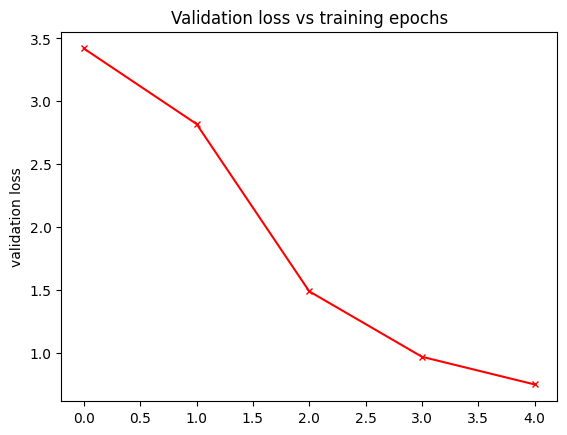

In [60]:
fig, ax2 = plt.subplots()
val_loss = [3.42, 2.82, 1.49, 0.97, 0.75]
# ax2 = ax.twinx()
ax2.plot(np.arange(len(task_optim_data)-1), val_loss,'x-', markersize=5, color='r', label='character error rate')
ax2.set_ylabel('validation loss')
ax.set_xlabel('Training epochs')
plt.title(f"Validation loss vs training epochs")

In [55]:
layer_7_corr = task_optim_data[-2]
layer_8_corr = task_optim_data[-1]
sorted_indices = np.argsort(layer_7_corr)

sorted_l7 = layer_7_corr[sorted_indices]
sorted_l8 = layer_8_corr[sorted_indices]

Text(0.5, 1.0, 'Ladder plot between epoch 4 and epoch 5 results')

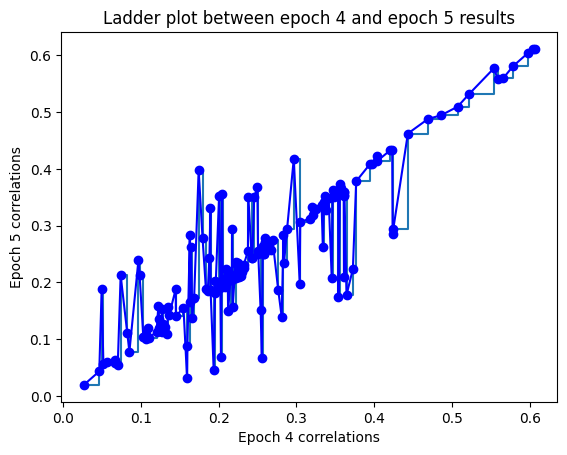

In [11]:
fig, ax = plt.subplots()
ax.step(sorted_l4, sorted_l5, where='post')

ax.plot(sorted_l4, sorted_l5, 'o-', color='blue')
ax.set_xlabel("Epoch 4 correlations")
ax.set_ylabel("Epoch 5 correlations")
ax.set_title("Ladder plot between epoch 4 and epoch 5 results")


[]

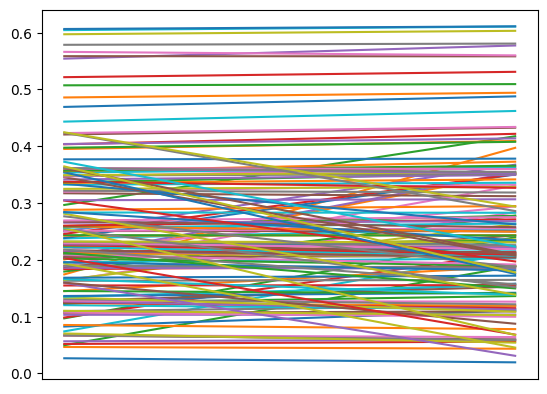

Text(0.5, 1.0, 'Ladder plot for epochs 7 and 8')

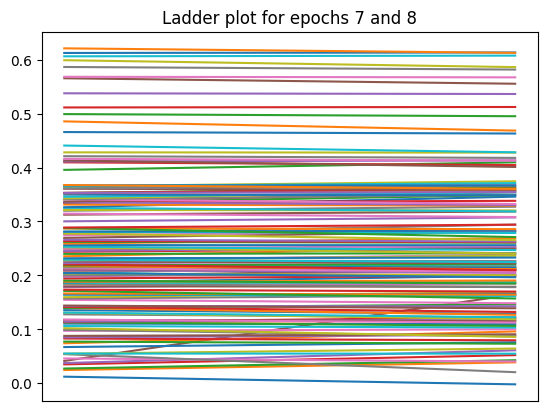

In [57]:
fig, ax = plt.subplots()
x_array = [0.1, 0.9]
for i, y1 in enumerate(sorted_l7):

    y_array = [sorted_l7[i], sorted_l8[i]]
    ax.plot(x_array, y_array)
ax.set_xticks([])
plt.title("Ladder plot for epochs 7 and 8")

In [142]:
file = filenames[epoch]
path = os.path.join(task_optim_dir, file)
e1_data = pd.read_csv(path)
select_data = e1_data[
                    # (e1_data['normalizer'] > threshold) & \
                    (e1_data['layer'] == layer) & \
                    (e1_data['session'] == 200213) & \
                    (e1_data['channel'] == 57)
                    # (e1_data['bin_width'] == bin_width) & \
                    # (e1_data['N_sents'] >= 499) & \
                    # (e1_data['delay'] == delay)
                    ]
select_data

,session,layer,channel,bin_width,delay,train_cc_raw,test_cc_raw,normalizer,N_sents
717,200213.0,5.0,57.0,20.0,0.0,0.116754,0.076301,0.101058,499.0


### earlier code...

In [2]:
# paths to read checkpoints from and save corr results at...
models_dir = config.task_optimization_paths['model_checkpoints_dir']
# saved_corr_results_dir = config.task_optimization_paths['saved_corr_results_dir']

saved_corr_results_dir = '/depot/jgmakin/data/auditory_cortex/saved_results/task_optimization'
task_optim_dir = '/depot/jgmakin/data/auditory_cortex/saved_results/task_optimization'

### Decoder matrix

#### Computing and saving betas..

In [13]:
epoch = 1
print(f"Creating regression object with weights trained for epochs: {epoch}")
model_name = 'wav2letter_modified'
obj = Reg.Regression load_features=True)

print("Computing betas....")
session = 200206
dict_key = f'beta_{session}_epoch{epoch}'
# Beta = obj.get_betas(session=session)

# get cross-validated betas...

corr_coeff, Beta = obj.cross_validated_regression(
    session=session,
    bin_width=20,
    k = 5,
    num_lmbdas=10,
    N=1
)


filename = 'decoder_matrix.pkl'
filepath = os.path.join(task_optim_dir, filename)
if os.path.isfile(filepath):
    print("Filepath exists, reading existing file...")
    with open(filepath, 'rb') as file:
        decoder_matrix = pickle.load(file)    
else:
    decoder_matrix = {}

# adding betas to the dictionary..
decoder_matrix[dict_key] = Beta.get()

print("Writing updated dictionary...")
with open(filepath, 'wb') as file:
    pickle.dump(decoder_matrix, file)

Creating regression object with weights trained for epochs: 1
Creating regression obj for: 'wav2letter_modified'
Loading features from checkpoint: /scratch/gilbreth/ahmedb/wav2letter/modified_w2l/Wav2letter-epoch=001-val_loss=3.42.ckpt
Loading ANN features at bin-width: 20
Computing betas....
# of iterations requested: 1, 
# of lambda samples per iteration: 10
Itr: 1:
K_fold for session: 200206
It takes (on avg.) 12.91 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 1.71 sec/mapping.
It takes (on avg.) 0.24 minutes/iteration...!
Filepath exists, reading existing file...
Writing updated dictionary...


In [7]:
filename = 'decoder_matrix.pkl'
filepath = os.path.join(task_optim_dir, filename)
if os.path.isfile(filepath):
    print("Filepath exists, reading existing file...")
   
else:
    print("File does not exist....")

Filepath exists, reading existing file...


In [5]:
# os.remove(filepath)

#### reading decoding matrix and visualizing...

In [14]:
filename = 'decoder_matrix.pkl'
filepath = os.path.join(task_optim_dir, filename)
if os.path.isfile(filepath):
    print("Filepath exists, reading existing file...")
    with open(filepath, 'rb') as file:
        decoder_matrix = pickle.load(file) 

Filepath exists, reading existing file...


In [15]:
decoder_matrix.keys()

dict_keys(['beta_200206_epoch4', 'beta_200206_epoch5', 'beta_200206_epoch7', 'beta_200206_epoch8', 'beta_200206_epoch6', 'beta_200206_epoch3', 'beta_200206_epoch2', 'beta_200206_epoch1'])

#### plotting the heatmap...

In [5]:
epoch = 4
layer_id = 6

layers = {5: 0, 6: 1, 7: 2}
id = layers[layer_id]
map = decoder_matrix[f'beta_200206_epoch{epoch}'][id]

fig, ax = plt.subplots()
ax.imshow(map, cmap='hot')

# plt.colorbar()
plt.show()

### pretrained weights evolution

In [12]:
results_dir = '/depot/jgmakin/data/auditory_cortex/correlation_results/cross_validated_correlations'
saved_checkpoints_dir = '/scratch/gilbreth/ahmedb/wav2letter/modified_w2l/' 

# checkpoint_e5 = 'Wav2letter-epoch=005-val_loss=0.75.ckpt'

In [31]:

checkpoint_file = 'Wav2letter-epoch=004-val_loss=0.97.ckpt'
checkpoint_path = os.path.join(saved_checkpoints_dir, checkpoint_file)
checkpoint4 = torch.load(checkpoint_path)


checkpoint_file = 'Wav2letter-epoch=005-val_loss=0.75.ckpt'
checkpoint_path = os.path.join(saved_checkpoints_dir, checkpoint_file)
checkpoint5 = torch.load(checkpoint_path)


In [35]:
layer = 6
print(f"Analyzing layer {layer}: ")
weights6_4 = checkpoint4['state_dict'][f'conv{layer+1}.conv.weight']
weights6_5 = checkpoint5['state_dict'][f'conv{layer+1}.conv.weight']

diff = weights6_5 - weights6_4
diff_norm = np.linalg.norm(diff.cpu())

normalized_diff_norm = diff_norm/np.sqrt(np.linalg.norm(weights6_4.cpu())* np.linalg.norm(weights6_5.cpu()))

print(f"Norm of difference of weights: {diff_norm:.2f}")
print(f"Norm of diff (normalized by individual norms): {normalized_diff_norm:.2f}")

Analyzing layer 6: 
Norm of difference of weights: 3.27
Norm of diff (normalized by individual norms): 0.27


In [36]:
layer = 10
print(f"Analyzing layer {layer}: ")
weights6_4 = checkpoint4['state_dict'][f'conv{layer+1}.conv.weight']
weights6_5 = checkpoint5['state_dict'][f'conv{layer+1}.conv.weight']

diff = weights6_5 - weights6_4
diff_norm = np.linalg.norm(diff.cpu())

normalized_diff_norm = diff_norm/np.sqrt(np.linalg.norm(weights6_4.cpu())* np.linalg.norm(weights6_5.cpu()))

print(f"Norm of difference of weights: {diff_norm:.2f}")
print(f"Norm of diff (normalized by individual norms): {normalized_diff_norm:.2f}")

Analyzing layer 10: 
Norm of difference of weights: 4.60
Norm of diff (normalized by individual norms): 0.30


### compute correlations and save to disk..

In [4]:


# read checkpoints from the directory..
checkpoints = []
for file_name in os.listdir(models_dir):
    if fnmatch.fnmatch(file_name, 'Wav2letter-epoch*.ckpt'):
        checkpoints.append(file_name)
checkpoints.sort()

# extract 'epochs' and 'loss' information from the checkpoint filenames...
pretrained_mdata = []
for checkpoint in checkpoints:
    # extract epoch number from latest checkpoint...
    upper_index = checkpoint.index('-val')
    lower_index = checkpoint.rfind('=', 0, upper_index) + 1
    epoch = int(checkpoint[lower_index:upper_index])

    # extract loss value from latest checkpoint...
    upper_index = checkpoint.index('.ckpt')
    lower_index = checkpoint.rfind('=', 0, upper_index) + 1
    loss = float(checkpoint[lower_index:upper_index])

    dictt = {'epochs': epoch,
             'loss': loss,
             'checkpoint': checkpoint
            }
    pretrained_mdata.append(dictt)

In [3]:
# running analysis...
i = 0
session = '200206'
bin_width = 20
delay = 20
epochs = pretrained_mdata[i]['epochs']
checkpoint = os.path.join(models_dir, pretrained_mdata[i]['checkpoint'])
corr_file_path = os.path.join(saved_corr_results_dir, f'w2l_epochs={epochs:02d}_session_{session}_corr.csv')

# compute correlations and save to disk...
reg_obj = helpers.get_regression_obj(session, checkpoint=checkpoint, load_features=True)
corr_results = reg_obj.cross_validated_regression(bin_width=bin_width, delay=delay, load_features=True, return_dict=True, numpy=False)
utils.write_to_disk(corr_results, corr_file_path)

#### Computing correlations for untrained model..

In [3]:
session = '200206'
bin_width = 20
delay = 0
epochs = 0 # pretrained_mdata[i]['epochs']
# checkpoint = os.path.join(models_dir, pretrained_mdata[i]['checkpoint'])
corr_file_path = os.path.join(saved_corr_results_dir, f'w2l_epochs={epochs:02d}_session_{session}_corr.csv')

# compute correlations and save to disk...
reg_obj = helpers.get_regression_obj(session, load_features=True, pretrained=False)
corr_results = reg_obj.cross_validated_regression(bin_width=bin_width, delay=delay, load_features=True, return_dict=True, numpy=False)
utils.write_to_disk(corr_results, corr_file_path)

Regression object...
Creating regression obj for: 'wav2letter_modified'
Loading ANN features at bin-width: 20
It takes 24.77 sec to load features...!
# of iterations requested: 10, 
# of lambda samples per iteration: 20
Itr: 1:
Itr: 2:
Itr: 3:
Itr: 4:
Itr: 5:
Itr: 6:
Itr: 7:
Itr: 8:
Itr: 9:
Itr: 10:
It takes (on avg.) 8.76 sec (all lmbdas). (time for 10-folds)
It takes (on avg.) 3.01 sec/mapping.
It takes (on avg.) 0.20 minutes/iteration...!
Data saved for model: 'wav2letter_modified', session: '200206',    bin-width: 20ms, delay: 0ms at file: '/depot/jgmakin/data/auditory_cortex/saved_results/task_optimization/w2l_epochs=00_session_200206_corr.csv'


,session,layer,channel,bin_width,delay,train_cc_raw,test_cc_raw,normalizer,N_sents
0,200206.0,0.0,0.0,20.0,0.0,0.106607,0.093577,0.0,499.0
1,200206.0,0.0,1.0,20.0,0.0,0.068458,0.045363,0.0,499.0
2,200206.0,0.0,2.0,20.0,0.0,0.06451,0.042679,0.0,499.0
3,200206.0,0.0,3.0,20.0,0.0,0.095561,0.080975,0.0,499.0
4,200206.0,0.0,4.0,20.0,0.0,0.073706,0.059724,0.0,499.0
...,...,...,...,...,...,...,...,...,...
763,200206.0,11.0,59.0,20.0,0.0,0.119621,0.119842,0.0,499.0
764,200206.0,11.0,60.0,20.0,0.0,0.11983,0.117963,0.0,499.0
765,200206.0,11.0,61.0,20.0,0.0,0.095794,0.094638,0.0,499.0
766,200206.0,11.0,62.0,20.0,0.0,0.131895,0.130001,0.0,499.0


### Read correlation results and analyse

In [4]:
layer = 6
task_optimization_summary = {
    'epochs' : [],
    'mean': [],
    'std': [],
    'max': []
}
corr_files = os.listdir(saved_corr_results_dir)
corr_files.sort()

for i, file_name in enumerate(corr_files):
    # Extract epoch and session info from the filename...
    upper_idx = file_name.rindex('_')
    lower_idx = file_name.rindex('_', 0, upper_idx)
    session = int(file_name[lower_idx+1: upper_idx])

    upper_idx = file_name.rindex('_session')
    lower_idx = file_name.rindex('=')
    epoch = int(file_name[lower_idx+1: upper_idx])
    if epoch < 24:
        # create correlation object and store the means and correlations...
        corr_file_path = os.path.join(saved_corr_results_dir, file_name)
        corr_obj = analysis.correlations(corr_file_path=corr_file_path)

        mn, std, mx = corr_obj.summarize(session=session, threshold=0)
        task_optimization_summary['epochs'].append(epoch)
        task_optimization_summary['mean'].append(mn[layer])
        task_optimization_summary['std'].append(std[layer])
        task_optimization_summary['max'].append(mx[layer])

# reading off these CER's from the lighting logs...
CER = [99, 27.33, 17.25, 15.58, 14.41, 13.37, 13.02]
acc = 1 - np.array(CER)
saved_results = '../../../saved_results/'

Text(0.5, 1.0, 'Corr. Coefficients (mean) vs training epochs (layer-6)')

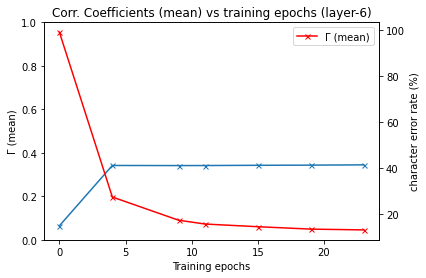

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(task_optimization_summary['epochs'], task_optimization_summary['mean'],'x-', markersize=5, label='\u0393 (mean)')
ax2.plot(task_optimization_summary['epochs'], CER,'x-', markersize=5, color='r', label='character error rate')
# plt.ylim([0, 0.5])
ax1.set_xlabel("Training epochs")
ax1.set_ylabel('\u0393 (mean)')
ax1.set_ylim(0, 1)

ax2.set_ylabel("character error rate (%)")
plt.legend(['\u0393 (mean)', 'character error rate'])
plt.title(f"Corr. Coefficients (mean) vs training epochs (layer-{layer})")
# plt.savefig(os.path.join(saved_results, 'svg_files',f'task_optimization_layer_{layer}.svg'))

# extra_axis_parameters = {
#     'width=\\figwidth',
#     'height=\\figheight',
#     'every x tick label/.append style={rotate=90}',
#     'xticklabel style={opacity=\\thisXticklabelopacity, align=center}',
# }
# tpl_save(
#     filepath=os.path.join(saved_results, 'tikz_files',f'task_optimization_layer_{layer}.tex'),
#     extra_axis_parameters=extra_axis_parameters,
#     tex_relative_path_to_data='pngs',
#     pre_tikzpicture_lines={
#         '\\providecommand{\\figwidth}{5.7in}%',
#         '\\providecommand{\\figheight}{2.0in}%',
#         '\\providecommand{\\thisXticklabelopacity}{1.0}%',
#     },
# )

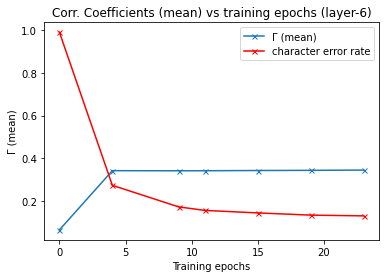

In [4]:
# fig, ax1 = plt.subplots()

plt.plot(task_optimization_summary['epochs'], task_optimization_summary['mean'],'x-', markersize=5, label='\u0393 (mean)')
plt.plot(task_optimization_summary['epochs'], CER,'x-', markersize=5, color='r', label='character error rate')
# plt.ylim([0, 0.5])
plt.xlabel("Training epochs")
plt.ylabel('\u0393 (mean)')
plt.legend()
plt.title(f"Corr. Coefficients (mean) vs training epochs (layer-{layer})")
plt.savefig(os.path.join(saved_results, 'svg_files',f'task_optimization_layer_{layer}.svg'))

# extra_axis_parameters = {
#     'width=\\figwidth',
#     'height=\\figheight',
#     'every x tick label/.append style={rotate=90}',
#     'xticklabel style={opacity=\\thisXticklabelopacity, align=center}',
# }
# tpl_save(
#     filepath=os.path.join(saved_results, 'tikz_files',f'task_optimization_layer_{layer}.tex'),
#     extra_axis_parameters=extra_axis_parameters,
#     tex_relative_path_to_data='pngs',
#     pre_tikzpicture_lines={
#         '\\providecommand{\\figwidth}{5.7in}%',
#         '\\providecommand{\\figheight}{2.0in}%',
#         '\\providecommand{\\thisXticklabelopacity}{1.0}%',
#     },
# )

In [32]:
!pwd

/home/ahmedb/projects/Wav2Letter/Auditory_Cortex/experiments/task_optimization


In [ ]:
output_dir = '../../../saved_results/svg_files/'

Text(0.5, 1.0, 'Corr. Coefficients (mean) vs accuracy (layer-6)')

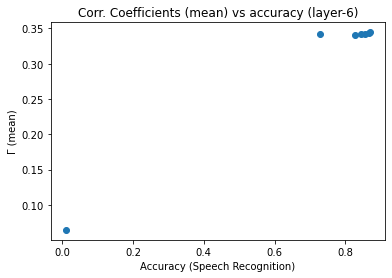

In [28]:
plt.scatter(acc, task_optimization_summary['mean'])#,'x-', markersize=5)
# plt.plot(task_optimization_summary['epochs'], ,'x-', markersize=5, color='r')
# plt.ylim([0, 0.5])
plt.xlabel("Accuracy (Speech Recognition)")
plt.ylabel('\u0393 (mean)')
plt.title(f"Corr. Coefficients (mean) vs accuracy (layer-{layer})")

In [11]:
task_optimization_summary['epochs']

[0, 4, 9, 11, 15, 19, 23]

In [7]:
task_optimization_summary['std']

[0.016051258799850854,
 0.13301249468769602,
 0.13324594348381205,
 0.13187312937098078,
 0.13263976248744117,
 0.13210839603824479,
 0.13104267672153003]

(0.0, 0.7)

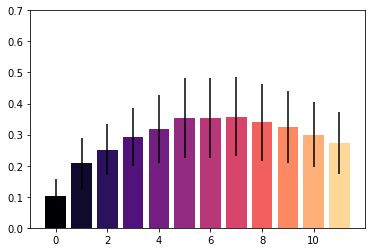

In [67]:
import matplotlib.cm as cm
cmap = cm.get_cmap('magma')
colors = cmap(np.arange(mn.shape[0])/12.0)
plt.bar(x=np.arange(mn.shape[0]), height=mn, yerr=std, color=colors)
plt.ylim([0, 0.7])